## Twitter sentiment analysis with BART Comparaison

### Import librairies

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer, WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# # Set style for visualizations
# plt.style.use('seaborn-v0_8')
# sns.set_palette("husl")

[nltk_data] Downloading package punkt to /Users/photoli93/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/photoli93/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/photoli93/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/photoli93/nltk_data...


### Loading data

In [6]:
# Load the dataset
# Note: Replace with actual path to your dataset
# For this example, we'll simulate loading the small dataset
def load_data():
    """Load the Twitter sentiment dataset"""
    try:
        df = pd.read_csv('../data/twitter_dataset_small_w_bart_preds.csv')
        print(f"Loaded dataset with shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except FileNotFoundError:
        print("Dataset file not found. Please ensure the file path is correct.")

df = load_data()
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
display(df.sample(5))

Loaded dataset with shape: (20000, 6)
Columns: ['is_positive', 'id', 'datetime', 'user', 'message', 'bart_is_positive']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_positive       20000 non-null  int64  
 1   id                20000 non-null  int64  
 2   datetime          20000 non-null  object 
 3   user              20000 non-null  object 
 4   message           20000 non-null  object 
 5   bart_is_positive  20000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 937.6+ KB
None

First few rows:


,is_positive,id,datetime,user,message,bart_is_positive
16381,0,2054277018,Sat Jun 06 06:59:39 PDT 2009,sammcote,STILL sick wtf is wrong with meeeee,0.000252
10628,0,1564878313,Mon Apr 20 05:13:43 PDT 2009,HCLordaeron,Behringer fun spoiled again,0.055950
9374,1,2014725765,Wed Jun 03 02:28:59 PDT 2009,shoreknee,"nothingggggggggggggggggggggg! bored as, feels ...",0.000741
18754,0,1966563909,Fri May 29 17:59:58 PDT 2009,VanessaCorsetti,@sheszladii the new curve.. Twitterberry is wack,0.007498
3859,1,2063133936,Sun Jun 07 01:29:33 PDT 2009,regnergarcia,the sun finally showed up. hello! we missed you!,0.645075


=== Dataset Overview ===
Total samples: 20000
Features: ['is_positive', 'id', 'datetime', 'user', 'message', 'bart_is_positive']

=== Missing Values ===
is_positive         0
id                  0
datetime            0
user                0
message             0
bart_is_positive    0
dtype: int64

=== Target Variable Distribution ===
is_positive
1    10058
0     9942
Name: count, dtype: int64
Positive ratio: 0.503

=== Text Statistics ===
        text_length    word_count
count  20000.000000  20000.000000
mean      74.321800     13.209500
std       36.389079      6.952138
min        7.000000      1.000000
25%       44.000000      7.000000
50%       70.000000     12.000000
75%      104.000000     19.000000
max      222.000000     41.000000


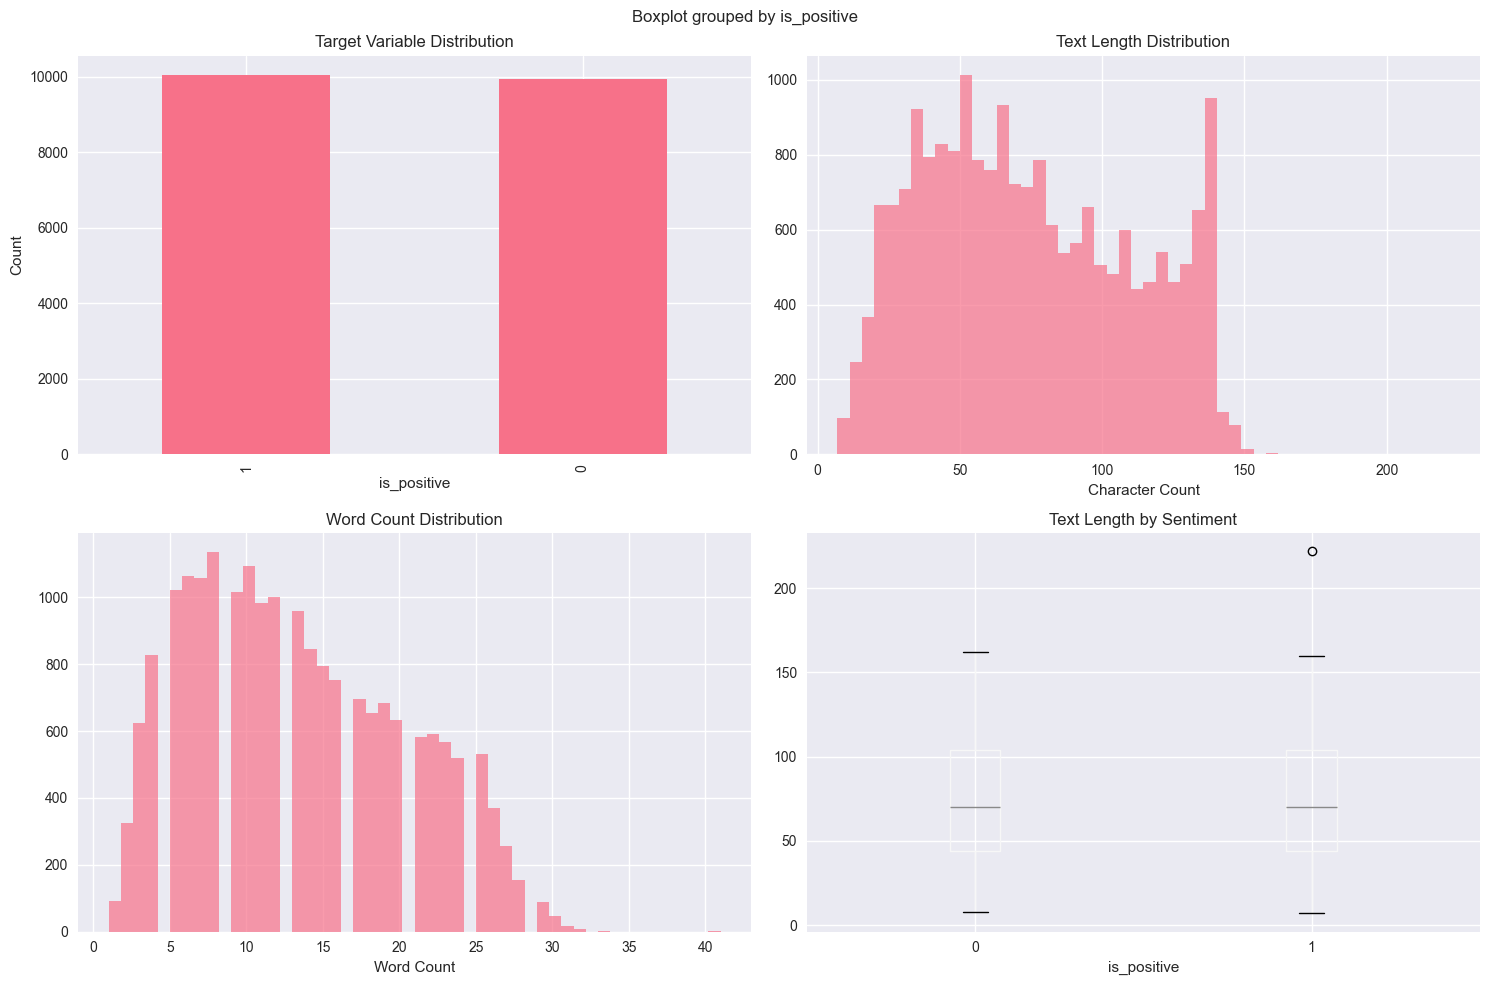

In [8]:
def explore_data(df):
    """Perform exploratory data analysis"""
    print("=== Dataset Overview ===")
    print(f"Total samples: {len(df)}")
    print(f"Features: {df.columns.tolist()}")
    
    # Check for missing values
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    
    # Target variable distribution
    print("\n=== Target Variable Distribution ===")
    target_counts = df['is_positive'].value_counts()
    print(target_counts)
    print(f"Positive ratio: {target_counts[1] / len(df):.3f}")
    
    # Text length statistics
    df['text_length'] = df['message'].str.len()
    df['word_count'] = df['message'].str.split().str.len()
    
    print("\n=== Text Statistics ===")
    print(df[['text_length', 'word_count']].describe())
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Target distribution
    target_counts.plot(kind='bar', ax=axes[0,0], title='Target Variable Distribution')
    axes[0,0].set_xlabel('is_positive')
    axes[0,0].set_ylabel('Count')
    
    # Text length distribution
    axes[0,1].hist(df['text_length'], bins=50, alpha=0.7)
    axes[0,1].set_title('Text Length Distribution')
    axes[0,1].set_xlabel('Character Count')
    
    # Word count distribution
    axes[1,0].hist(df['word_count'], bins=50, alpha=0.7)
    axes[1,0].set_title('Word Count Distribution')
    axes[1,0].set_xlabel('Word Count')
    
    # Text length by sentiment
    df.boxplot(column='text_length', by='is_positive', ax=axes[1,1])
    axes[1,1].set_title('Text Length by Sentiment')
    
    plt.tight_layout()
    plt.show()
    
    return df

df = explore_data(df)

In [19]:
from collections import Counter
from wordcloud import WordCloud
import string
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def comprehensive_eda(df):
    """Perform comprehensive exploratory data analysis"""
    print("=" * 80)
    print("COMPREHENSIVE EXPLORATORY DATA ANALYSIS")
    print("=" * 80)
    
    # Basic dataset info
    print("\n=== Dataset Overview ===")
    print(f"Total samples: {len(df):,}")
    print(f"Features: {df.columns.tolist()}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Missing values analysis
    print("\n=== Missing Values Analysis ===")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    })
    print(missing_df[missing_df['Missing Count'] > 0])
    
    if missing_df['Missing Count'].sum() == 0:
        print("✅ No missing values found!")
    
    # Duplicate analysis
    print(f"\n=== Duplicate Analysis ===")
    duplicate_count = df.duplicated().sum()
    duplicate_text_count = df['message'].duplicated().sum()
    print(f"Complete duplicates: {duplicate_count:,}")
    print(f"Text duplicates: {duplicate_text_count:,}")
    
    if duplicate_text_count > 0:
        print("Sample duplicate texts:")
        duplicate_texts = df[df['message'].duplicated(keep=False)]['message'].value_counts().head(3)
        for text, count in duplicate_texts.items():
            print(f"  '{text[:100]}...' appears {count} times")
    
    return df

comprehensive_eda(df)

COMPREHENSIVE EXPLORATORY DATA ANALYSIS

=== Dataset Overview ===
Total samples: 20,000
Features: ['is_positive', 'id', 'datetime', 'user', 'message', 'bart_is_positive', 'text_length', 'word_count']
Memory usage: 6.19 MB

=== Missing Values Analysis ===
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
✅ No missing values found!

=== Duplicate Analysis ===
Complete duplicates: 0
Text duplicates: 21
Sample duplicate texts:
  'Good morning ...' appears 4 times
  'Goodnight ...' appears 3 times
  'Headache ...' appears 3 times


,is_positive,id,datetime,user,message,bart_is_positive,text_length,word_count
0,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...,0.005163,111,19
1,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,Young_J,I'm off too bed. I gotta wake up hella early t...,0.339430,63,12
2,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,dougnawoschik,I havent been able to listen to it yet My spe...,0.065703,62,13
3,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,thireven,now remembers why solving a relatively big equ...,0.004046,98,18
4,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,taracollins086,"Ate too much, feel sick",0.000581,24,5
...,...,...,...,...,...,...,...,...
19995,1,2051447103,Fri Jun 05 22:02:36 PDT 2009,_Jaska,@girlwonder24 Thanks.,0.886532,22,2
19996,0,2245469948,Fri Jun 19 16:10:39 PDT 2009,julianicolao,"trying to study for the biggest test, next wee...",0.001541,80,15
19997,1,2063022808,Sun Jun 07 01:05:46 PDT 2009,ElaineToni,Just finished watching Your Song Presents: Boy...,0.326061,53,7
19998,1,1982082859,Sun May 31 10:29:36 PDT 2009,lindseyrd20,@janfran813 awww i can't wait to get one,0.881646,41,8


In [20]:
df.user.value_counts()

user
keza34             7
AnotherJulia       6
radha_             6
JBnVFCLover786     6
SarahSaner         5
                  ..
juleslovescramm    1
MyPuppyPlanner     1
hugo_agogo         1
suzanella          1
serraannisa        1
Name: count, Length: 18931, dtype: int64